# Wavenet Architecture

We would like to take more characters in a sequence as an input not just three and in addition to that we don't just want to feed them all into a single hidden layer because that squashes too much information too quickly instead we would like to make a deeper model that progressively fuses this information to make its guess about
the next character in a sequence and so we'll see that as we make this architecture more complex we're actually going to arrive at something that looks very much like a wavenet

In WaveNet, when predicting the next character in a sequence, it uses the previous characters as input. Instead of processing all characters in a single layer, it gradually combines them. Specifically, it starts by pairing two characters together (creating bigrams) and representing them visually. This process continues, grouping bigrams into larger chunks of four characters, and so on. This hierarchical approach allows the network to progressively integrate information from previous characters as it deepens, effectively building context layer by layer.

In [16]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [17]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
print(len(words))
print(max(len(w) for w in words))
print(words[:8])

32033
15
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


In [18]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [19]:
# shuffle up the words
import random
random.seed(42)
random.shuffle(words)

In [20]:
# build the dataset
block_size = 8 # context-length: how many characters do we take to predict the next one

def build_dataset(words):
    X, Y = [], []
    
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # crop and append
            
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
# 80 10 10 split
Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 8]) torch.Size([182625])
torch.Size([22655, 8]) torch.Size([22655])
torch.Size([22866, 8]) torch.Size([22866])


In [21]:
for x, y in zip(Xtr[:20], Ytr[:20]):
    print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

........ --> y
.......y --> u
......yu --> h
.....yuh --> e
....yuhe --> n
...yuhen --> g
..yuheng --> .
........ --> d
.......d --> i
......di --> o
.....dio --> n
....dion --> d
...diond --> r
..diondr --> e
.diondre --> .
........ --> x
.......x --> a
......xa --> v
.....xav --> i
....xavi --> e


Matrix multiplication in this context operates specifically on the last dimension of the input tensor, while keeping all preceding dimensions unchanged. This means that any dimensions before the last one are treated as batch dimensions, allowing you to handle multiple sets of data simultaneously. Essentially, you can perform the matrix multiplication across all inputs in parallel, which is efficient and convenient for processing large batches of data.

Instead of transforming all eight characters into one eight-dimensional vector and then multiplying it by a weight matrix (which would be inefficient), we propose grouping the characters into pairs. This means taking every two consecutive characters and treating them as separate groups. By doing this, we aim to process these four pairs in parallel, effectively introducing a "batch dimension" for more efficient computation.


Lets say we are getting [1 2 3 4 5 6 7 8] in a single input so what we want is is to divide computations into groups of two and make it parallel:
                                    (1, 2) (3, 4) (5, 6) (7, 8)

Basically transformed the input from 
                            M x 8 x C   ----->   M x 4 x 2 x C

When combined for computation
                            M x 8C      ----->   M x 4 x 2C

In [22]:
# -----------------------------------------------------------------------------------------------
class Linear:
    
    def __init__(self, fan_in, fan_out, bias = True):
        self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5 # note: kaiming init
        self.bias = torch.randn(fan_out) if bias else None
        
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])
    
# -----------------------------------------------------------------------------------------------
class BatchNorm1d:
    
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        #parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        #buffers (trained with a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
        
    def __call__(self, x):
        # calculate the forward pass
        if self.training:
            if x.ndim == 2:
                dim = 0
            elif x.ndim == 3:
                dim = (0, 1)    
            xmean = x.mean(dim, keepdim=True) # batch mean
            xvar = x.var(dim, keepdim=True) # batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
        self.out = self.gamma * xhat + self.beta
        # update the buffers
        if(self.training):
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]
    
# -----------------------------------------------------------------------------------------------
class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

# -----------------------------------------------------------------------------------------------
class Embedding:
    
    def __init__(self, num_embeddings, embedding_dim):
        self.weight = torch.randn((num_embeddings, embedding_dim))
        
    def __call__(self, IX):
        self.out = self.weight[IX]
        return self.out
    
    def parameters(self):
        return [self.weight]
    
# -----------------------------------------------------------------------------------------------
class FlattenConsecutive:
    
    def __init__(self, n):
        self.n = n
        
    def __call__(self, x):
        B, T, C = x.shape
        x = x.view(B, T//self.n, C*self.n)
        if(x.shape[1] == 1):  # spurious dimension
            x = x.squeeze(1)
        self.out = x
        return self.out
        
    def parameters(self):
        return []
    
# -----------------------------------------------------------------------------------------------
class Sequential:
    
    def __init__(self, layers):
        self.layers = layers
    
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out
    
    def parameters(self):
        # get parameters for all the layers and stretch them out into one list
        return [p for layer in self.layers for p in layer.parameters()]

# WHY DOES THIS BATCHNORM DOES NOT WORK CORRECTLY NOW?

In [23]:
e = torch.randn(32, 4, 68)
emean = e.mean(0, keepdim=True) # 1, 4, 68
evar = e.var(0, keepdim=True) # 1, 4, 68
ehat = (e - emean) / torch.sqrt(evar + 1e-5)
ehat.shape

torch.Size([32, 4, 68])



Input Dimensions: The input to the layer has the shape 32 x 4 x 68. This means there are 32 samples in the batch, each with 4 different feature sets (or groups) and 68 channels.

Mean Calculation: The code calculates the mean by performing a mean operation along the first dimension (dimension 0). This is done using x.mean(dim=0), which means the mean is calculated over all 32 samples for each of the 4 feature sets and 68 channels. This reduces the output shape to 1 x 4 x 68, resulting in one mean value for each of the 4 features and 68 channels.

Maintained Dimensions: The computed means and variances maintain their shape of 1 x 4 x 68, meaning they are calculated separately for each feature position (4 positions) and each channel (68 channels).

Running Mean: The running mean, which is typically used in batch normalization to keep track of the average during training, also has a shape of 1 x 4 x 68. This indicates that the normalization is treating the feature dimensions independently, rather than treating the entire input as a single batch across all 68 channels.

Desired Behavior: The explanation emphasizes that instead of treating the 4 feature positions independently, the batch normalization should consider these four positions as part of a combined batch. The goal is to average over 32 x 4 = 128 numbers for each of the 68 channels, to compute the statistics correctly. This means that both the batch size and the feature dimensions should be treated in a unified manner for calculating mean and variance across all 128 numbers, instead of calculating them separately for each of the four feature sets.

In [24]:
e = torch.randn(32, 4, 68)
emean = e.mean((0, 1), keepdim=True) # 1, 1, 68
evar = e.var((0, 1), keepdim=True) # 1, 1, 68
ehat = (e - emean) / torch.sqrt(evar + 1e-5)
ehat.shape

torch.Size([32, 4, 68])

In [25]:
torch.manual_seed(42); # seed rng for reproducibility

In [26]:
# original network
# n_embd = 10 # the dimensionality of the character embedding vectors
# n_hidden = 300 # the number of neurons in the hidden layer of the MLP
# model = Sequential([
#   Embedding(vocab_size, n_embd),
#   FlattenConsecutive(8), Linear(n_embd * 8, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
#   Linear(n_hidden, vocab_size),
# ])

# hierarchical network
n_embd = 24 # the dimensionality of the character embedding vectors
n_hidden = 128 # the number of neurons in the hidden layer of the MLP
model = Sequential([
  Embedding(vocab_size, n_embd),
  FlattenConsecutive(2), Linear(n_embd * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  FlattenConsecutive(2), Linear(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  FlattenConsecutive(2), Linear(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(n_hidden, vocab_size),
])

# parameter init
with torch.no_grad():
  model.layers[-1].weight *= 0.1 # last layer make less confident

parameters = model.parameters()
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

76579


In [27]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  logits = model(Xb)
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update: simple SGD
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

      0/ 200000: 4.6212
  10000/ 200000: 2.1471
  20000/ 200000: 1.5086
  30000/ 200000: 2.1991
  40000/ 200000: 2.0678
  50000/ 200000: 1.8111
  60000/ 200000: 2.3209
  70000/ 200000: 1.9109
  80000/ 200000: 1.5972
  90000/ 200000: 1.8337
 100000/ 200000: 2.0202
 110000/ 200000: 2.2274
 120000/ 200000: 1.8608
 130000/ 200000: 2.1748
 140000/ 200000: 1.7984
 150000/ 200000: 2.0833
 160000/ 200000: 2.1612
 170000/ 200000: 1.7996
 180000/ 200000: 1.7231
 190000/ 200000: 1.8490


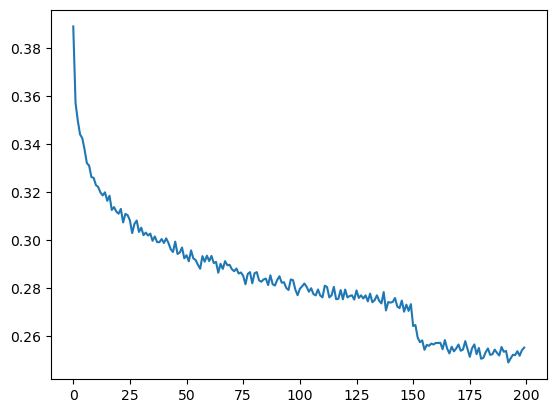

In [28]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

In [30]:
# put layers into eval mode (needed for batchnorm especially)
for layer in model.layers:
  layer.training = False

In [31]:
# evaluate the loss
@torch.no_grad() # this decorator disables gradient tracking inside pytorch
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  logits = model(x)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 1.7673866748809814
val 1.9882051944732666


In [32]:
# sample from the model
for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      logits = model(torch.tensor([context]))
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out)) # decode and print the generated word

jerrel.
annamya.
sverita.
nolme.
ida.
rmion.
raquel.
ettel.
kellyn.
hamed.
hilda.
jahmir.
klorley.
mooben.
menda.
maddie.
adalyne.
hangelone.
killion.
kierstine.


# Why convolutions? In the original Paper : https://arxiv.org/abs/1609.03499 

In [33]:
for x,y in zip(Xtr[7:15], Ytr[7:15]):
  print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

........ --> d
.......d --> i
......di --> o
.....dio --> n
....dion --> d
...diond --> r
..diondr --> e
.diondre --> .


In [34]:
# forward a single example:
logits = model(Xtr[[7]])
logits.shape

torch.Size([1, 27])

In [35]:
# forward all of them
logits = torch.zeros(8, 27)
for i in range(8):
  logits[i] = model(Xtr[[7+i]])
logits.shape

torch.Size([8, 27])

-> convolution is a "for loop" ->allows us to forward Linear layers efficiently over space